# Sentiment Analysis - Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import os
import re
import nltk
import string
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

## Data Loading

In [2]:
train_data_path = "./trainingandtestdata/training.1600000.processed.noemoticon.csv"
df_train = pd.read_csv(train_data_path,encoding='latin-1', header=None)

In [3]:
df_train.head(10)

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   0       1600000 non-null  int64 
 1   1       1600000 non-null  int64 
 2   2       1600000 non-null  object
 3   3       1600000 non-null  object
 4   4       1600000 non-null  object
 5   5       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [5]:
test_data_path = "./trainingandtestdata/testdata.manual.2009.06.14.csv"
df_test = pd.read_csv(test_data_path,encoding='latin-1', header=None)
df_test.head()

,0,1,2,3,4,5
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...


## Data Exploration
### Examine target class distribution


800000 0 800000


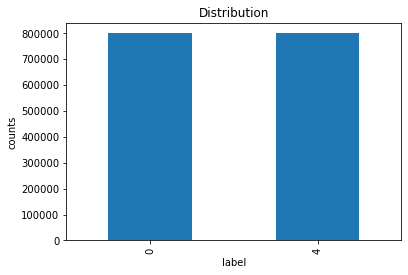

In [6]:
num_0 = len(df_train[df_train[0]==0])
num_2 = len(df_train[df_train[0]==2])
num_4 = len(df_train[df_train[0]==4])
print(num_0,num_2,num_4)

pd.value_counts(df_train[0]).plot.bar()
plt.title('Distribution')
plt.xlabel('label')
plt.ylabel('counts')
plt.show()

The target class distribution of the training data is examined. The dataset contains only positive (label 4) and negative (label 0) tweets, and no neutral tweets. The number of samples for positive and negative tweets are balanced.

### Drop irrelevant columns
The original data contains 6 fields. The id, date and user fields are dropped because they are irrelevant to sentiment analysis. The flag field has a lot of NO_QUERY entries, so it is likely not helpful, and dropped. The only remaining fields retained are target and text.

In [7]:
df_train_d = df_train.drop(columns=[1,2,3,4])
df_train_d.head()

,0,5
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


### Examine length of Tweets

In [8]:
# count number of characters in each tweet
df_train_d['char'] = df_train_d[5].apply(lambda x: len(x))
df_train_d.head()

,0,5,char
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",115
1,0,is upset that he can't update his Facebook by ...,111
2,0,@Kenichan I dived many times for the ball. Man...,89
3,0,my whole body feels itchy and like its on fire,47
4,0,"@nationwideclass no, it's not behaving at all....",111


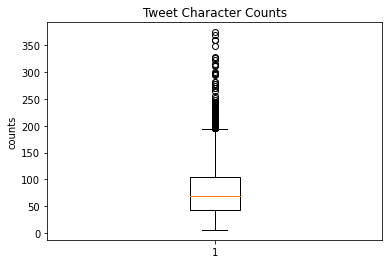

In [9]:
plt.boxplot(df_train_d['char'])
plt.title('Tweet Character Counts')
plt.ylabel('counts')
plt.show()

The length of the string in text is examined. The length distribution is shown above in the box plot. 

## Data Preprocessing

Some information in the tweets does not help in this task of sentiment analysis. For example, HTML encodings, user mentions, punctuations. They are removed.

### Remove HTML encodings

In [10]:
def removeHTML(text):
    return re.sub(r'\&\w*;', '', text)

df_train_d['cleantweet'] = df_train_d[5].apply(removeHTML)
df_train_d.head(20)

,0,5,char,cleantweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",115,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...,111,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...,89,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire,47,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all....",111,"@nationwideclass no, it's not behaving at all...."
5,0,@Kwesidei not the whole crew,29,@Kwesidei not the whole crew
6,0,Need a hug,11,Need a hug
7,0,@LOLTrish hey long time no see! Yes.. Rains a...,99,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,@Tatiana_K nope they didn't have it,36,@Tatiana_K nope they didn't have it
9,0,@twittera que me muera ?,25,@twittera que me muera ?


### Remove @mention, non letter characters & convert to lowercase

In [11]:
def textprocess(text):
    # Remove @mention
    text = re.sub('@[^\s]+','',text)
    # Remove URL
    text = re.sub(r'https?:\/\/.*\/\w*', '', text)
    # Remove hashtags
    text = re.sub(r'#\w*', '', text)
    # Remove Punctuation and 's, 'd, 've
    text = re.sub(r'[' + string.punctuation.replace('@', '') + ']+', ' ', text)
    text = re.sub(r'\b\w{1,2}\b', '', text)
    # Remove numbers
    text = re.sub(r'[0-9]', '', text)
    # Remove whitespace (including new line characters)
    text = re.sub(r'\s\s+', ' ', text)
    # Remove single space remaining at the front of the tweet.
    text = text.lstrip(' ') 
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    text = ''.join(c for c in text if c <= '\uFFFF') 
    return text.lower() # Convert to lowercase

df_train_d['cleantweet'] = df_train_d['cleantweet'].apply(textprocess)
df_train_d.head(20)

,0,5,char,cleantweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",115,awww that bummer you shoulda got david carr th...
1,0,is upset that he can't update his Facebook by ...,111,upset that can update his facebook texting and...
2,0,@Kenichan I dived many times for the ball. Man...,89,dived many times for the ball managed save the...
3,0,my whole body feels itchy and like its on fire,47,whole body feels itchy and like its fire
4,0,"@nationwideclass no, it's not behaving at all....",111,not behaving all mad why here because can see ...
5,0,@Kwesidei not the whole crew,29,not the whole crew
6,0,Need a hug,11,need hug
7,0,@LOLTrish hey long time no see! Yes.. Rains a...,99,hey long time see yes rains bit only bit lol f...
8,0,@Tatiana_K nope they didn't have it,36,nope they didn have
9,0,@twittera que me muera ?,25,que muera


### Remove stopwords and tokenization

**Stop Words:** A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) that a search engine has been programmed to ignore, both when indexing entries for searching and when retrieving them as the result of a search query. 
We would not want these words to take up space in our database, or taking up valuable processing time.

Ref: https://www.geeksforgeeks.org/removing-stop-words-nltk-python/

In [12]:

import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = text.split()
    filtered_words = []
    for w in words:
        if w not in stop_words:
            filtered_words.append(w)
    return filtered_words

df_train_d['words'] = df_train_d['cleantweet'].apply(remove_stopwords)
df_train_d.head()

,0,5,char,cleantweet,words
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",115,awww that bummer you shoulda got david carr th...,"[awww, bummer, shoulda, got, david, carr, thir..."
1,0,is upset that he can't update his Facebook by ...,111,upset that can update his facebook texting and...,"[upset, update, facebook, texting, might, cry,..."
2,0,@Kenichan I dived many times for the ball. Man...,89,dived many times for the ball managed save the...,"[dived, many, times, ball, managed, save, rest..."
3,0,my whole body feels itchy and like its on fire,47,whole body feels itchy and like its fire,"[whole, body, feels, itchy, like, fire]"
4,0,"@nationwideclass no, it's not behaving at all....",111,not behaving all mad why here because can see ...,"[behaving, mad, see]"


### Stemming

Stemming reduces words to their root forms, which may result in words that may or may not exist in natural language. But it is a useful natural language processing technique to help programs work with natural language.

Ref: https://www.datacamp.com/community/tutorials/stemming-lemmatization-python


In [13]:
# nltk.download('punkt')
# nltk.download('wordnet')

In [14]:
from nltk.stem import PorterStemmer
porter = PorterStemmer()
# wordnet_lemmatizer = WordNetLemmatizer()

def stemmer(words):
    stem_words = []
    for w in words:
        stem_words.append(porter.stem(w))
    return ' '.join(w for w in stem_words) 

df_train_d['words'] = df_train_d['words'].apply(stemmer)
df_train_d.head()

,0,5,char,cleantweet,words
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",115,awww that bummer you shoulda got david carr th...,awww bummer shoulda got david carr third day
1,0,is upset that he can't update his Facebook by ...,111,upset that can update his facebook texting and...,upset updat facebook text might cri result sch...
2,0,@Kenichan I dived many times for the ball. Man...,89,dived many times for the ball managed save the...,dive mani time ball manag save rest bound
3,0,my whole body feels itchy and like its on fire,47,whole body feels itchy and like its fire,whole bodi feel itchi like fire
4,0,"@nationwideclass no, it's not behaving at all....",111,not behaving all mad why here because can see ...,behav mad see


### Save clean tweets to file

In [16]:
df_train_clean = df_train_d[[0,'words']]
df_train_clean.head()
df_train_clean.to_csv('clean_train.csv', index=False)

## Data Visualization
### Word Cloud of Negative Words

In [17]:
neg_words =' '.join([str(text) for text in df_train_clean['words'][df_train_clean[0] == 0]]) 

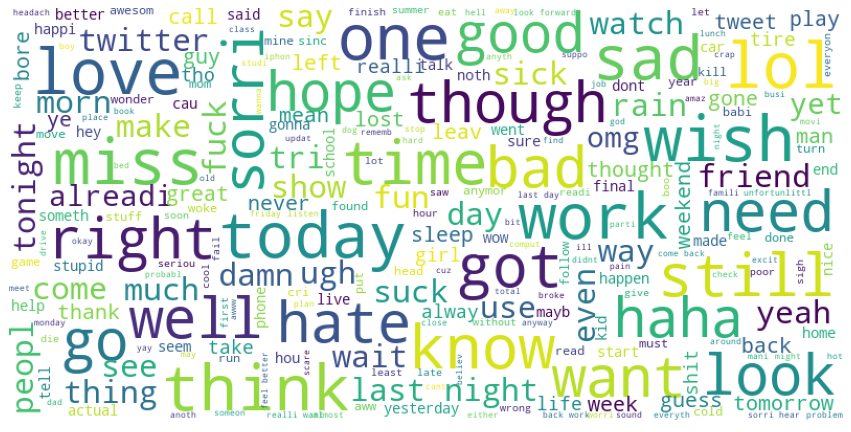

In [18]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=250,
        max_font_size=30,
        scale=2).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=30)
        fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud)
    plt.show()

wordcloud(neg_words)

### Word Cloud of Positive Words

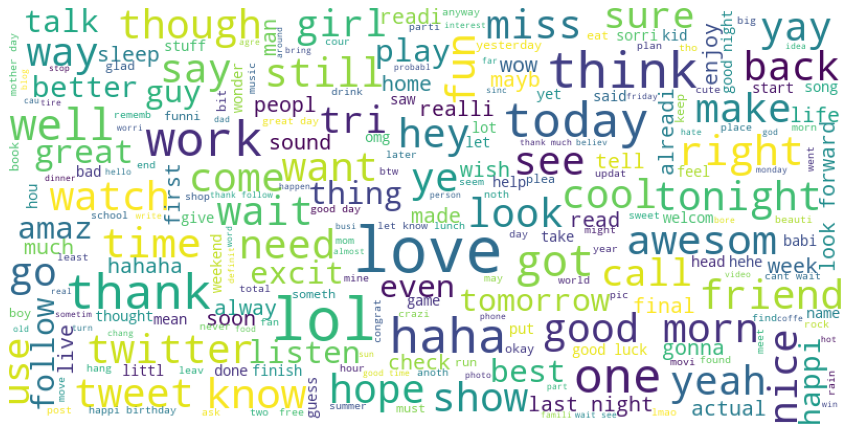

In [19]:
pos_words =' '.join([str(text) for text in df_train_clean['words'][df_train_clean[0] == 4]]) 
wordcloud(pos_words)

The words “hate” and “sad” are found in the negative word cloud with maximum font size. This is not surprising since Twitter is common with hate speech and spreading news. Most news that are popular are unhappy events. In the positive word cloud, “lol” is spotted with maximum font size, which also occurs in the negative word cloud. This is probably because the usage of “lol” can mean both “laugh out loud” and sarcasm in different context. It is difficult to judge whether a single word is used in positive or negative sentiment on its own without the context.

### Extract term frequency data
Explore what words are used in the tweets, and how many times they are used in the entire corpus.

In [48]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()

train_counts = count_vect.fit_transform(df_train_clean['words'])
total_counts = train_counts.sum(axis=0)

pos_counts = train_counts[:800000].sum(axis=0) 
neg_counts = train_counts[800000:].sum(axis=0)

In [54]:
total_counts = total_counts.tolist()[0]
pos_counts = pos_counts.tolist()[0]
neg_counts = neg_counts.tolist()[0]

In [58]:
freq_data = {'Word': count_vect.get_feature_names(),
            'negative': neg_counts,
            'positive': pos_counts,
            'total': total_counts}
freq_data_df = pd.DataFrame(freq_data)
freq_data_df = freq_data_df.sort_values('total', ascending=False)
freq_data_df.head()

/Users/yunlinlew/miniforge3/envs/NLP/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Word,negative,positive,total
73100,get,49227,61554,110781
45673,day,56880,52104,108984
75670,good,62807,29680,92487
215451,work,28770,58966,87736
110743,like,40540,43248,83788


In [59]:
freq_data_df.to_csv('word_freq.csv', index=False)

### Tweet token visualization
Visualize the top 50 words in positive tweets and negative tweets respectively.

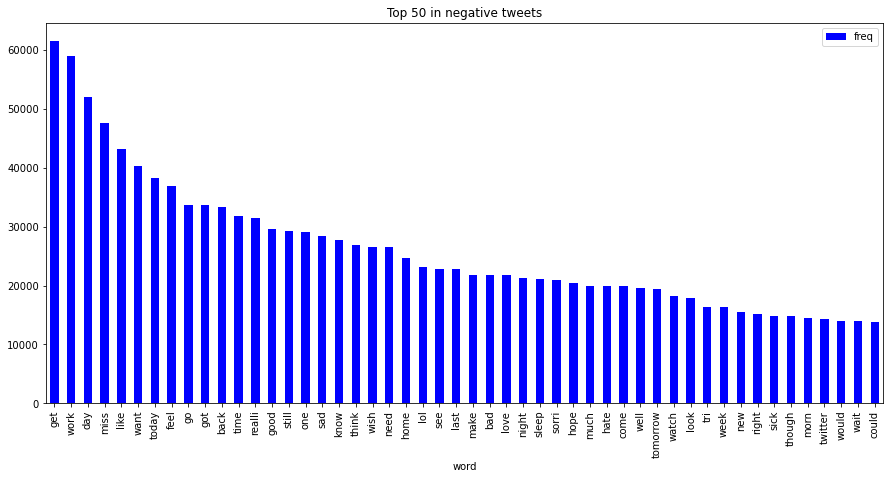

In [75]:
neg_count_vect = CountVectorizer()
neg_train_counts = neg_count_vect.fit_transform(df_train_clean[df_train_clean[0]==0]['words'])
sum_words = neg_train_counts.sum(axis=0)
words_freq = [(word, sum_words[0, i]) for word, i in neg_count_vect.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])
frequency.head(50).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title("Top 50 in negative tweets")
plt.show()

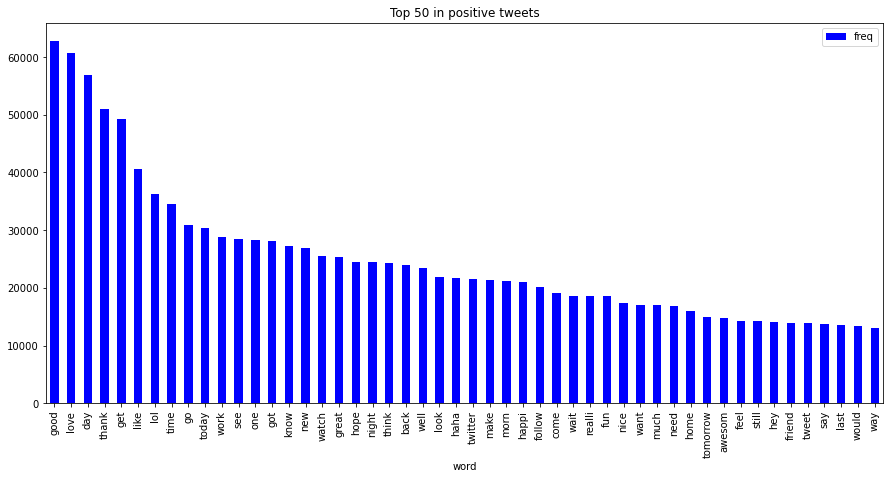

In [79]:
pos_count_vect = CountVectorizer()
pos_train_counts = pos_count_vect.fit_transform(df_train_clean[df_train_clean[0]==4]['words'])
sum_words = pos_train_counts.sum(axis=0)
words_freq = [(word, sum_words[0, i]) for word, i in pos_count_vect.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])
frequency.head(50).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title("Top 50 in positive tweets")
plt.show()

The word “get” is the most frequent in negative tweets. More than 75% of the negative tweets contain this word. The second most frequent word is “work”. This is not surprising because people like to rant or complain about work on social media. The top 5 words occur in at least half of the negative tweet samples. Some surprising words include “good” and “love”, which at first impression would be positive words. 

# Test data processing 
(For model validation in downstream sentiment analysis task)

In [81]:
df_test_d = df_test.drop(columns=[1,2,3,4])

df_test_d['cleantweet'] = df_test_d[5].apply(removeHTML)

df_test_d['cleantweet'] = df_test_d['cleantweet'].apply(textprocess)

df_test_d['words'] = df_test_d['cleantweet'].apply(remove_stopwords)

porter = PorterStemmer()

df_test_d['words'] = df_test_d['words'].apply(stemmer)

df_test_clean = df_train_d[[0,'words']]
df_test_clean.head()

,0,words
0,0,awww bummer shoulda got david carr third day
1,0,upset updat facebook text might cri result sch...
2,0,dive mani time ball manag save rest bound
3,0,whole bodi feel itchi like fire
4,0,behav mad see


In [82]:
df_test_clean.to_csv('cleantest.csv', index=False) # save clean tweets to file